In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors as knn

# KNN

## Titanic
Vamos a crear un modelo que prediga la probabilidad de supervivencia de los pasajeros

https://www.kaggle.com/c/titanic/data?select=train.csv

0. Importar data de training y testing. Agregarle a la tabla de testing la columna survived proveniente de la tabla gender_submission

In [7]:
training = pd.read_csv('train.csv', sep=',')
testing = pd.read_csv('test.csv', sep=',')
gendersub = pd.read_csv('gender_submission.csv', sep=',')
testing['Survived'] = testing['PassengerId'].map(gendersub.set_index('PassengerId')['Survived'])

1. Buscar columnas con valores nulos y cantidad de nulos en cada una. Fijarse el porcentaje de los datos nulos que representan sobre el total.

In [10]:
tnulos = training.isnull().sum()
filas = training.shape[0]
porcentaje_tnulos = ((tnulos / filas) * 100).round(2)
porcentaje_tnulos

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

2. En base al resultado anterior. ¿Cúales columnas consideran que tienen sentido completar y cuales se deberían eliminar? Eliminar la que corresponda de la tabla de test y de train.

In [13]:
training.drop(columns=['Cabin'], inplace=True)
testing.drop(columns=['Cabin'], inplace=True)

3. Completar valores nulos con el criterio que considres correcto en cada una de las columnas (que tengan sentido completar). Esto debe hacerse tanto en la tabla de training como la de testing (con el mismo criterio en ambas).

   Verificar como se distribuyen los valores de cada columna con un gráfico previamente para tener más herramientas en la decisión

In [16]:
training["Age"] = training["Age"].fillna(training.groupby(["Sex", "Pclass"])["Age"].transform("median"))
testing["Age"] = testing["Age"].fillna(testing.groupby(["Sex", "Pclass"])["Age"].transform("median"))

In [18]:
training["Embarked"] = training["Embarked"].fillna(training["Embarked"].mode()[0])
testing["Embarked"] = testing["Embarked"].fillna(testing["Embarked"].mode()[0])

In [19]:
testing["Fare"] = testing["Fare"].fillna(testing.groupby(["Sex", "Pclass"])["Fare"].transform("mean"))

4. Realizar análisis exploratorio. Graficar las personas que sobrevivieron por:
    - Clase (Pclass)
    - Sexo (Sex)
    - Costo de boleto (Fare)

<Axes: xlabel='Pclass', ylabel='count'>

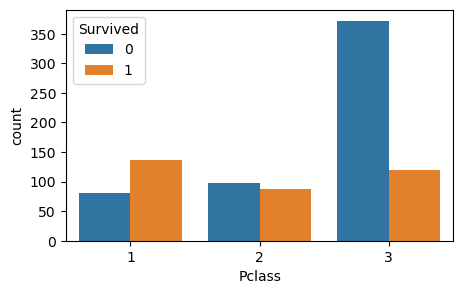

In [23]:
plt.figure(figsize=(5, 3))
#sns.histplot(data = training, x='Pclass', hue='Survived', kde=True)
sns.countplot(data = training, x = "Pclass", hue = "Survived")

<Axes: xlabel='Sex', ylabel='count'>

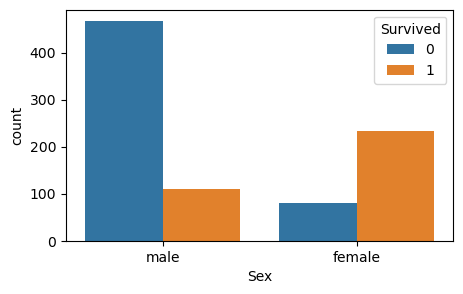

In [25]:
plt.figure(figsize=(5, 3))
#sns.histplot(data = training, x='Sex', hue='Survived', kde=True)sns.countplot(data = train_data, x = "Sex", hue = "Survived")
sns.countplot(data = training, x = "Sex", hue = "Survived")

(0.0, 100.0)

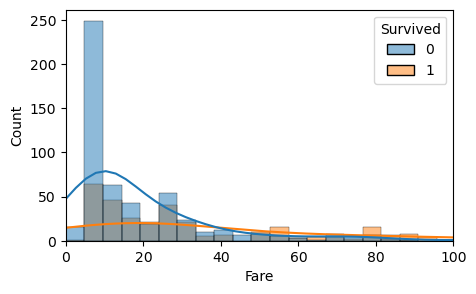

In [27]:
plt.figure(figsize=(5, 3))
sns.histplot(data = training, x='Fare', hue='Survived', kde=True)
plt.xlim(0,100)

5. Verificar columnas del DataFrame e identificar sobre cuales se deberían generar variables dummies.
   Generar columnas de dummies sobre "Pclass","Embarked" y "Sex". Aplicar cambios en training y testing

In [30]:
training = pd.get_dummies(
    training, 
    columns=["Pclass","Embarked","Sex"],
    drop_first = True
)

testing = pd.get_dummies(
    testing, 
    columns=["Pclass","Embarked","Sex"],
    drop_first = True
)

6. Eliminar columnas del dataset que considere que no suman al modelo. Hacerlo en testing y training

In [33]:
training = training.drop(columns=['SibSp','Parch','Ticket','PassengerId','Name'])
testing = testing.drop(columns=['SibSp','Parch','Ticket','PassengerId','Name'])

In [35]:
training.columns.size == testing.columns.size

True

7. Agregar una columna llamada "IsMinor" que sea 1 en caso de tener 16 años o menos y 0 en caso contrario. Hacerlo para testing y training

In [38]:
training["IsMinor"] = np.where(training["Age"]<=16, 1, 0)
testing["IsMinor"] = np.where(testing["Age"]<=16, 1, 0)

8. Ajustar modelo considerando todas las variables del dataset de training.

In [41]:
X_train = training.loc[:,training.columns != "Survived"]
y_train = training.loc[:, "Survived"]

modelo = knn.KNeighborsClassifier(n_neighbors = 5)
modelo.fit(X_train, y_train)

KNeighborsClassifier()

9. Validar el modelo con datos de testing, agregar columna con cluster a test_data

In [44]:
training.drop(columns = "y_pred", inplace=True)

KeyError: "['y_pred'] not found in axis"

In [50]:
X_test = testing.loc[:,testing.columns != "Survived"]
y_real = testing["Survived"]

In [52]:
testing["y_pred"] = modelo.predict(X_test) 
testing.head()

,Age,Fare,Survived,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,IsMinor,y_pred
0,34.5,7.8292,0,False,True,True,False,True,0,0
1,47.0,7.0000,1,False,True,False,True,False,0,0
2,62.0,9.6875,0,True,False,True,False,True,0,0
3,27.0,8.6625,0,False,True,False,True,True,0,0
4,22.0,12.2875,1,False,True,False,True,False,0,0


10. Calcular matriz de confusión

In [57]:
matriz_confusion = confusion_matrix(y_test, y_pred)
matriz_confusion

NameError: name 'y_test' is not defined

In [59]:
matriz_confusion = confusion_matrix(
    testing["Survived"],
    testing["y_pred"]
)
matriz_confusion

array([[197,  69],
       [ 75,  77]], dtype=int64)

In [61]:
TN = matriz_confusion[0][0]
TP = matriz_confusion[1][1]
FN = matriz_confusion[1][0]
FP = matriz_confusion[0][1]

11. Calcular Accuracy

In [64]:
# Accuracy
(TN+TP) / (TN+TP+FN+FP)

0.6555023923444976

12. Calcular sensibilidad

In [67]:
# Sensibilidad Recall o True Positive Rate
TP / (TP + FN)

0.506578947368421

13. Calcular especificidad

In [70]:
# Especificidad True Negative Rate
TN / (TN + FP)

0.7406015037593985